# Classification of Pulsar Stars 


We will be classifying the dataset HTRU2 which describes a sample of pulsar candidates with multiple observations distinguishing between a pulsar star and a non-pulsar star. A pulsar star is a celestial source of pulsating electromagnetic radiation (such as radio waves) characterized by a short relatively constant interval between pulses that is held to be a rotating neutron star(Lorimer & Kramer, 2012). They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter(Shaw, 2021). The data was collected based on the radio signals transmitted from either an actual pulsar star or random interference radio waves from space. Each observation was then classified as either an actual pulsar star, or something else entirely. Currently, these pulsar stars are used as instruments by scientists by utilizing their pulses of radiation to detect gravitational waves in the galaxy. These gravitational waves are then used to study the extreme states of matter, and find statistics of other heavenly bodies outside of the Earth’s solar system. In order to aid in furthering the knowledge about outer space, a classification model was created in order to find out whether a body is a pulsar star or not using certain characteristics observed.

In [32]:
### Run this cell before continuing. 
library(repr)
library(tidyverse)
library(tidymodels)
require(gridExtra)
library(GGally)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

## Preliminary exploratory data analysis:


The data was downloaded from https://archive.ics.uci.edu/ml/datasets/HTRU2. The completeness of the data was first checked, and it was found that there were no missing data.

The data was then uploaded to github where it was loaded from, then wrangled locally.

In [33]:
link_for_csv <- "https://raw.githubusercontent.com/Raikenken/dsci100project/master/HTRU_2.csv?token=GHSAT0AAAAAABTM7LEMAZZOQJAKBHV2EDMIYSSIKQA"

pulsar_data <- read_csv(link_for_csv, col_names = FALSE)

header_official_names <- c("Mean of the integrated profile",
                           "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile",
                           "Skewness of the integrated profile",
                           "Mean of the DM-SNR curve",
                           "Standard deviation of the DM-SNR curve",
                           "Excess kurtosis of the DM-SNR curve",
                           "Skewness of the DM-SNR curve",
                           "Class")

header_names <- c("int_prof_mean",
                  "int_prof_standard_deviation",
                  "int_prof_excess_kurtosis",
                  "int_prof_skewness",
                  "dm_snr_mean",
                  "dm_snr_standard_deviation",
                  "dm_snr_excess_kurtosis",
                  "dm_snr_skewness",
                  "class")



colnames(pulsar_data) <- header_names

pulsar_data <- pulsar_data %>%
                   mutate(class = as_factor(class))

head(pulsar_data, 6)

ERROR: Error in open.connection(con, "rb"): HTTP error 404.


Since the dataset's observations were not ordered or arranged, they were already random enough to get a sample manually without any additional methods for randomization. Due to the large size of the dataset, an equal amount of pulsar and non-pulsar star observations were taken. The amount decided for each class is 1500 observations. This would be large enough to train our model without giving it too much bias.

In [34]:
set.seed(3)

select_pulsars <- filter(pulsar_data, class == 1) %>%
    slice_sample(n = 1500)

select_non_pulsars <- filter(pulsar_data, class == 0) %>%
    slice_sample(n = 1500)

sampled_data <- bind_rows(select_pulsars, select_non_pulsars) 

sampled_data 

mutated_sampled_data <- sampled_data %>%
    group_by(class) %>%
    summarize(count = n()) %>%
    mutate(percentage = 100*(count/sum(count)))

mutated_sampled_data

int_prof_mean,int_prof_standard_deviation,int_prof_excess_kurtosis,int_prof_skewness,dm_snr_mean,dm_snr_standard_deviation,dm_snr_excess_kurtosis,dm_snr_skewness,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
71.39844,40.67907,2.262237,6.299383,31.655518,64.22590,1.96598362,2.7144769,1
21.07812,39.20930,4.619731,21.427812,110.481605,73.16369,0.02967964,-0.9828384,1
54.31250,37.62080,3.104716,13.390595,5.271739,28.14779,6.09455006,39.3313271,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
77.71094,34.58462,0.88761871,4.18582553,2.152174,12.74579,10.0857356,149.099577,0
102.35156,51.22752,0.56682023,0.04534184,3.779264,21.39546,7.6526177,66.935699,0
140.98438,45.68780,-0.02057498,0.32656435,85.194816,91.01114,0.1576488,-1.918349,0


`summarise()` ungrouping output (override with `.groups` argument)



class,count,percentage
<fct>,<int>,<dbl>
0,1500,50
1,1500,50


In order to create an optimal model, the data was split into a training and testing dataset, where 75% is the training data, while the rest are the testing data. A 75-25 split was decided as 75% is meaningful enough to train the data, and that 25% is also enough to tell whether the model predicted correctly and reduces the amount of luck involved for the results.

In [35]:
set.seed(1)

pulsar_split <- initial_split(sampled_data, prop = 0.75, strata = class)
training_set <- training(pulsar_split)
testing_set <- testing(pulsar_split)

The number below shows the amount of n\a data observations within our data set. As you can see, there are none!

The tibble below showcases the amount of each of our different classifications within the dataset, along with the percentage totals.

In [36]:
count(training_set)

n
<int>
2250


In [37]:
sum(is.na(pulsar_data))

mutated_training_data <- pulsar_data %>%
    group_by(class) %>%
    summarize(count = n()) %>%
    mutate(percentage = 100*(count/sum(count)))

mutated_training_data

[1] 0

`summarise()` ungrouping output (override with `.groups` argument)



class,count,percentage
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


In this study, all the variables would be used to train the model. These would be the mean, standard deviation, excess kurtosis, and skewness of the integrated pulse profile and the DM-SNR Curve. As seen from the plots of the statistics of the Integrated Profile vs DM-SNR curve, there is a good distinction whether one is a pulsar or not, so the model is expected to provide a good accuracy in classifying whether a star is a pulsar.

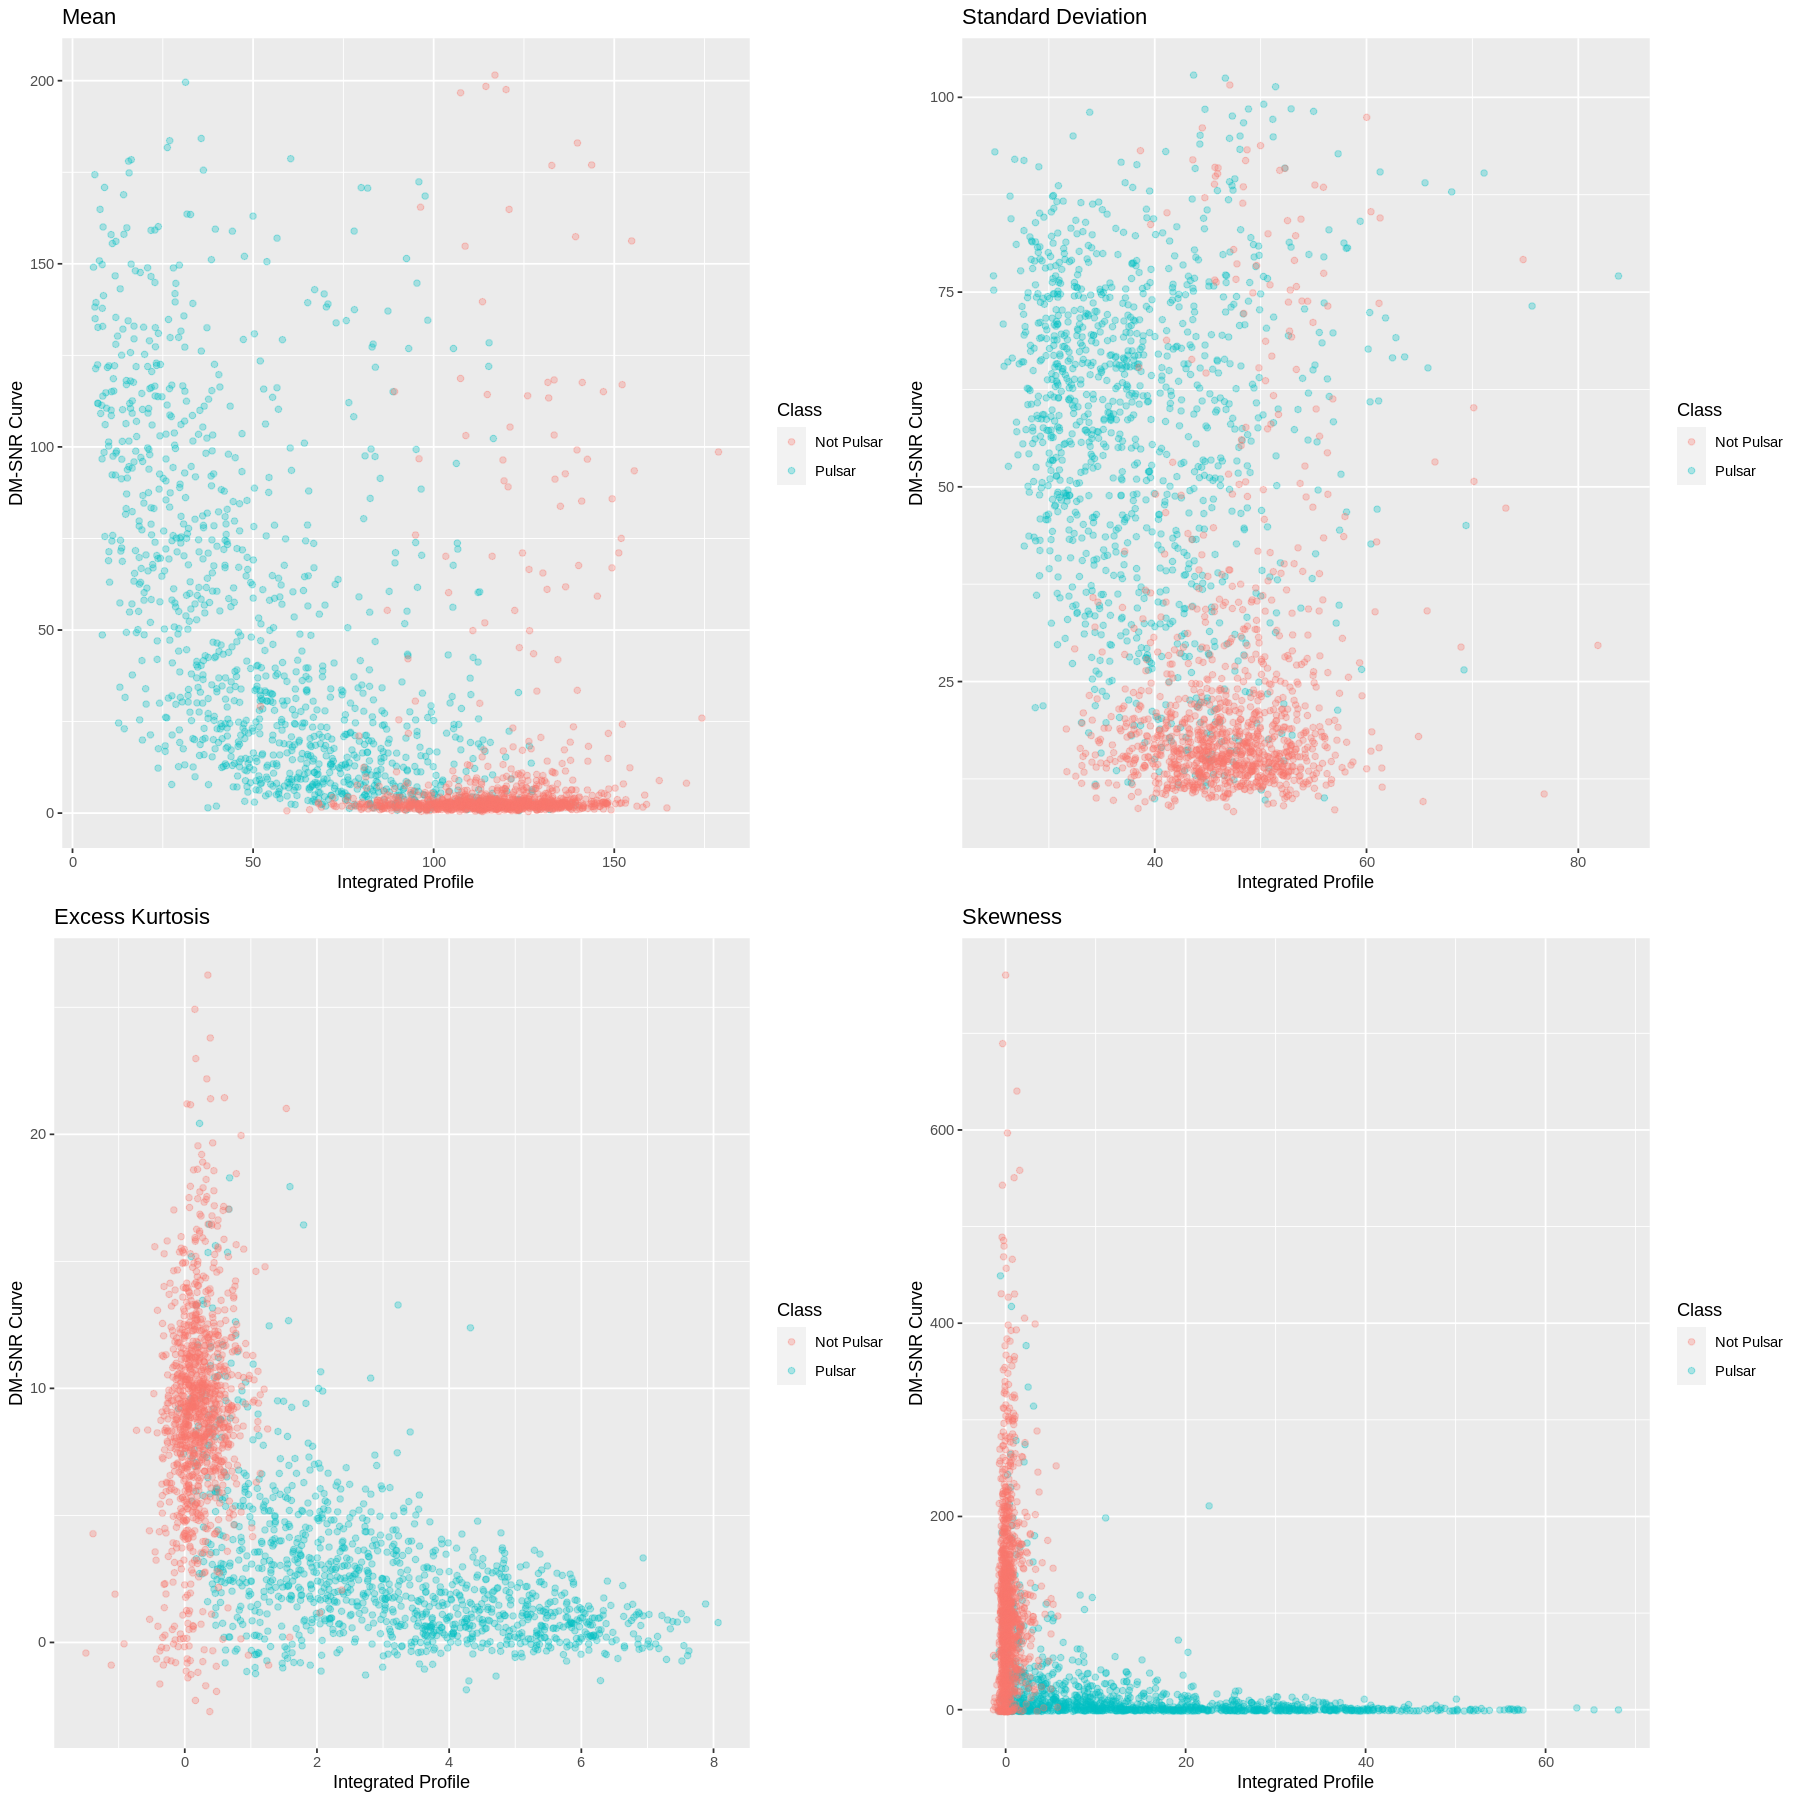

In [38]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_plot_mean <-  ggplot(training_set, aes(x = int_prof_mean, 
                                                      y = dm_snr_mean, 
                                                      colour = class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Mean",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_plot_stan_dev <-  ggplot(training_set, aes(x = int_prof_standard_deviation, 
                                                 y = dm_snr_standard_deviation, 
                                                 colour = class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Standard Deviation",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_plot_excess_kurtosis <-  ggplot(training_set, aes(x = int_prof_excess_kurtosis, 
                                                        y = dm_snr_excess_kurtosis, 
                                                        colour = class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Excess Kurtosis",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_plot_skewness <-  ggplot(training_set, aes(x = int_prof_skewness, 
                                                 y = dm_snr_skewness, 
                                                 colour = class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Skewness",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

grid.arrange(pulsar_plot_mean,
             pulsar_plot_stan_dev,
             pulsar_plot_excess_kurtosis,
             pulsar_plot_skewness,
             ncol = 2)

**Figure 1:** Plots of the statistics of Integrated Profile vs DM-SNR Curve

From the plots in Figure 1 above, it is observable that each variable has a significant effect on the classification whether a star is a pulsar, so all of the variables, except the class, would be used to train the model. Additionally, due to the distinct positioning of the data points on the plots, a k nearest neighbors model would be a good predictor whether a star is a pulsar. Furthermore, the training dataset was split into training and validation sets inside a 5 fold cross-validation algorithm and was checked for the neighbors with values 1 to 30. This allows us to find how many neighbors are the best for our k-nearest neighbors algorithm. From the results, it shows that 29 is the best number of neighbors, so the model was then trained again to have n=29 for its number of neighbors. The model was then tested on the testing dataset and was shown to have an accuracy of about 92.93%


In [39]:
set.seed(2020)

# Create vfold
pulsar_vfold <- vfold_cv(training_set, v = 5, strata = class)

# Create recipe for number recognition
pulsar_recipe <- recipe(class ~ . , data = training_set) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Create KNN for tuning k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

# create KNN Results
gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 2))

knn_results <- workflow() %>%
      add_recipe(pulsar_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = gridvals) %>%
      collect_metrics()

# create TIBBLE for accuracy results of potential k values
accuracies <- knn_results %>% 
      filter(.metric  == "accuracy")

In [40]:
k_min <- accuracies %>%
   arrange(mean) %>% 
   tail(1) %>%
   select(neighbors) %>%
   pull()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
      set_engine("kknn") %>%
      set_mode("classification")

pulsar_fit <- workflow() %>%
      add_recipe(pulsar_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = training_set)

pulsar_predictions <- predict(pulsar_fit, testing_set) %>%
    bind_cols(testing_set)

pulsar_metrics <- metrics(pulsar_predictions, truth = class, estimate = .pred_class )

pulsar_conf_mat <- conf_mat(pulsar_predictions, truth = class, estimate = .pred_class)

k_min
pulsar_predictions
pulsar_metrics
pulsar_conf_mat

[1] 5

.pred_class,int_prof_mean,int_prof_standard_deviation,int_prof_excess_kurtosis,int_prof_skewness,dm_snr_mean,dm_snr_standard_deviation,dm_snr_excess_kurtosis,dm_snr_skewness,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,68.90625,50.13535,1.940450,3.891114,75.966555,79.82690,0.6940737,-0.7855076,1
1,70.24219,62.11591,1.467381,1.379963,80.698161,75.42230,0.5166247,-0.8915771,1
0,69.21094,35.25724,1.093096,4.435122,2.345318,20.20026,9.3896133,91.7508170,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,143.60938,46.58565,-0.1605510,0.5664545,2.439799,16.71682,10.813226,137.65972,0
0,121.47656,45.77799,0.0874162,0.1979956,3.430602,19.43752,6.750373,52.39071,0
0,77.71094,34.58462,0.8876187,4.1858255,2.152174,12.74579,10.085736,149.09958,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9293333
kap,binary,0.8586667


          Truth
Prediction   0   1
         0 358  36
         1  17 339

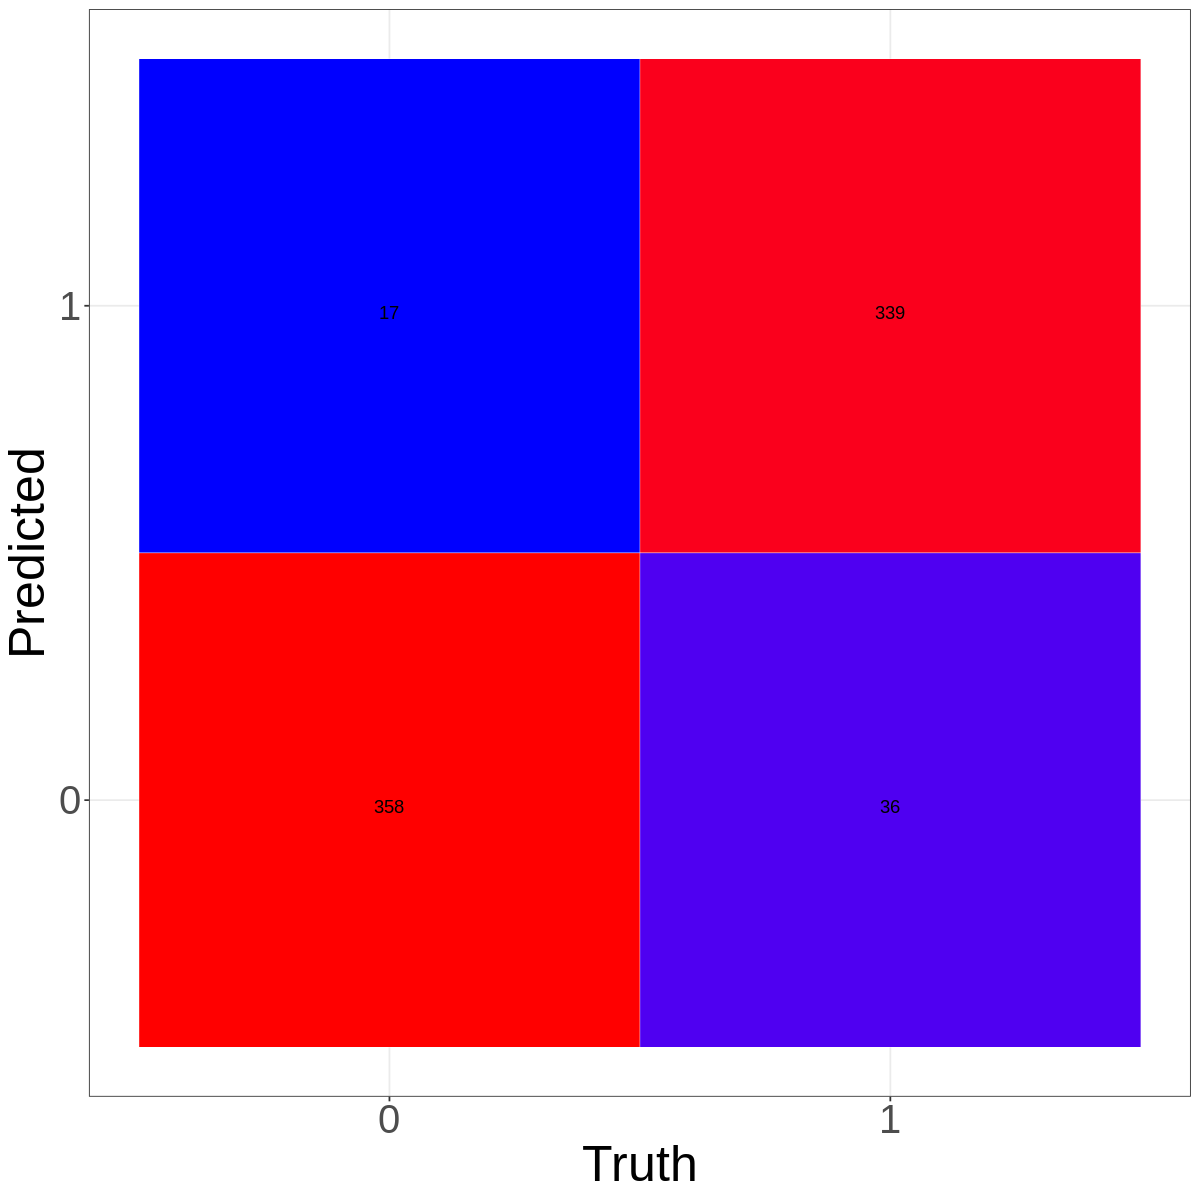

In [43]:
options(repr.plot.width = 10, repr.plot.height = 10)

TClass <- factor(c(1, 1, 0, 0))
PClass <- factor(c(1, 0, 1, 0))
Y      <- c(339, 36, 17, 358)
df <- data.frame(TClass, PClass, Y)

library(ggplot2)
    ggplot(data =  df, mapping = aes(x = TClass, y = PClass)) +
    geom_tile(aes(fill = Y), colour = "white") +
    geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
    scale_fill_gradient(low = "blue", high = "red") +
    theme_bw() + theme(legend.position = "none") +
    xlab("Truth") +
    ylab("Predicted") +
    theme(text = element_text(size = 30))

**Figure 2:** Visualization of Confusion Matrix

As we can see from this confusion matrix plot in Figure 2, there were 358 True Negatives and 339 True positivies. This means that at 750 data points, the model predicted 697 points correctly. With 17 False Positives and 36 False Negatives, that means that the model only made 53 wrong predictions. This is a good starting point to show that a k nearest neighbors model performs well in this type of dataset.

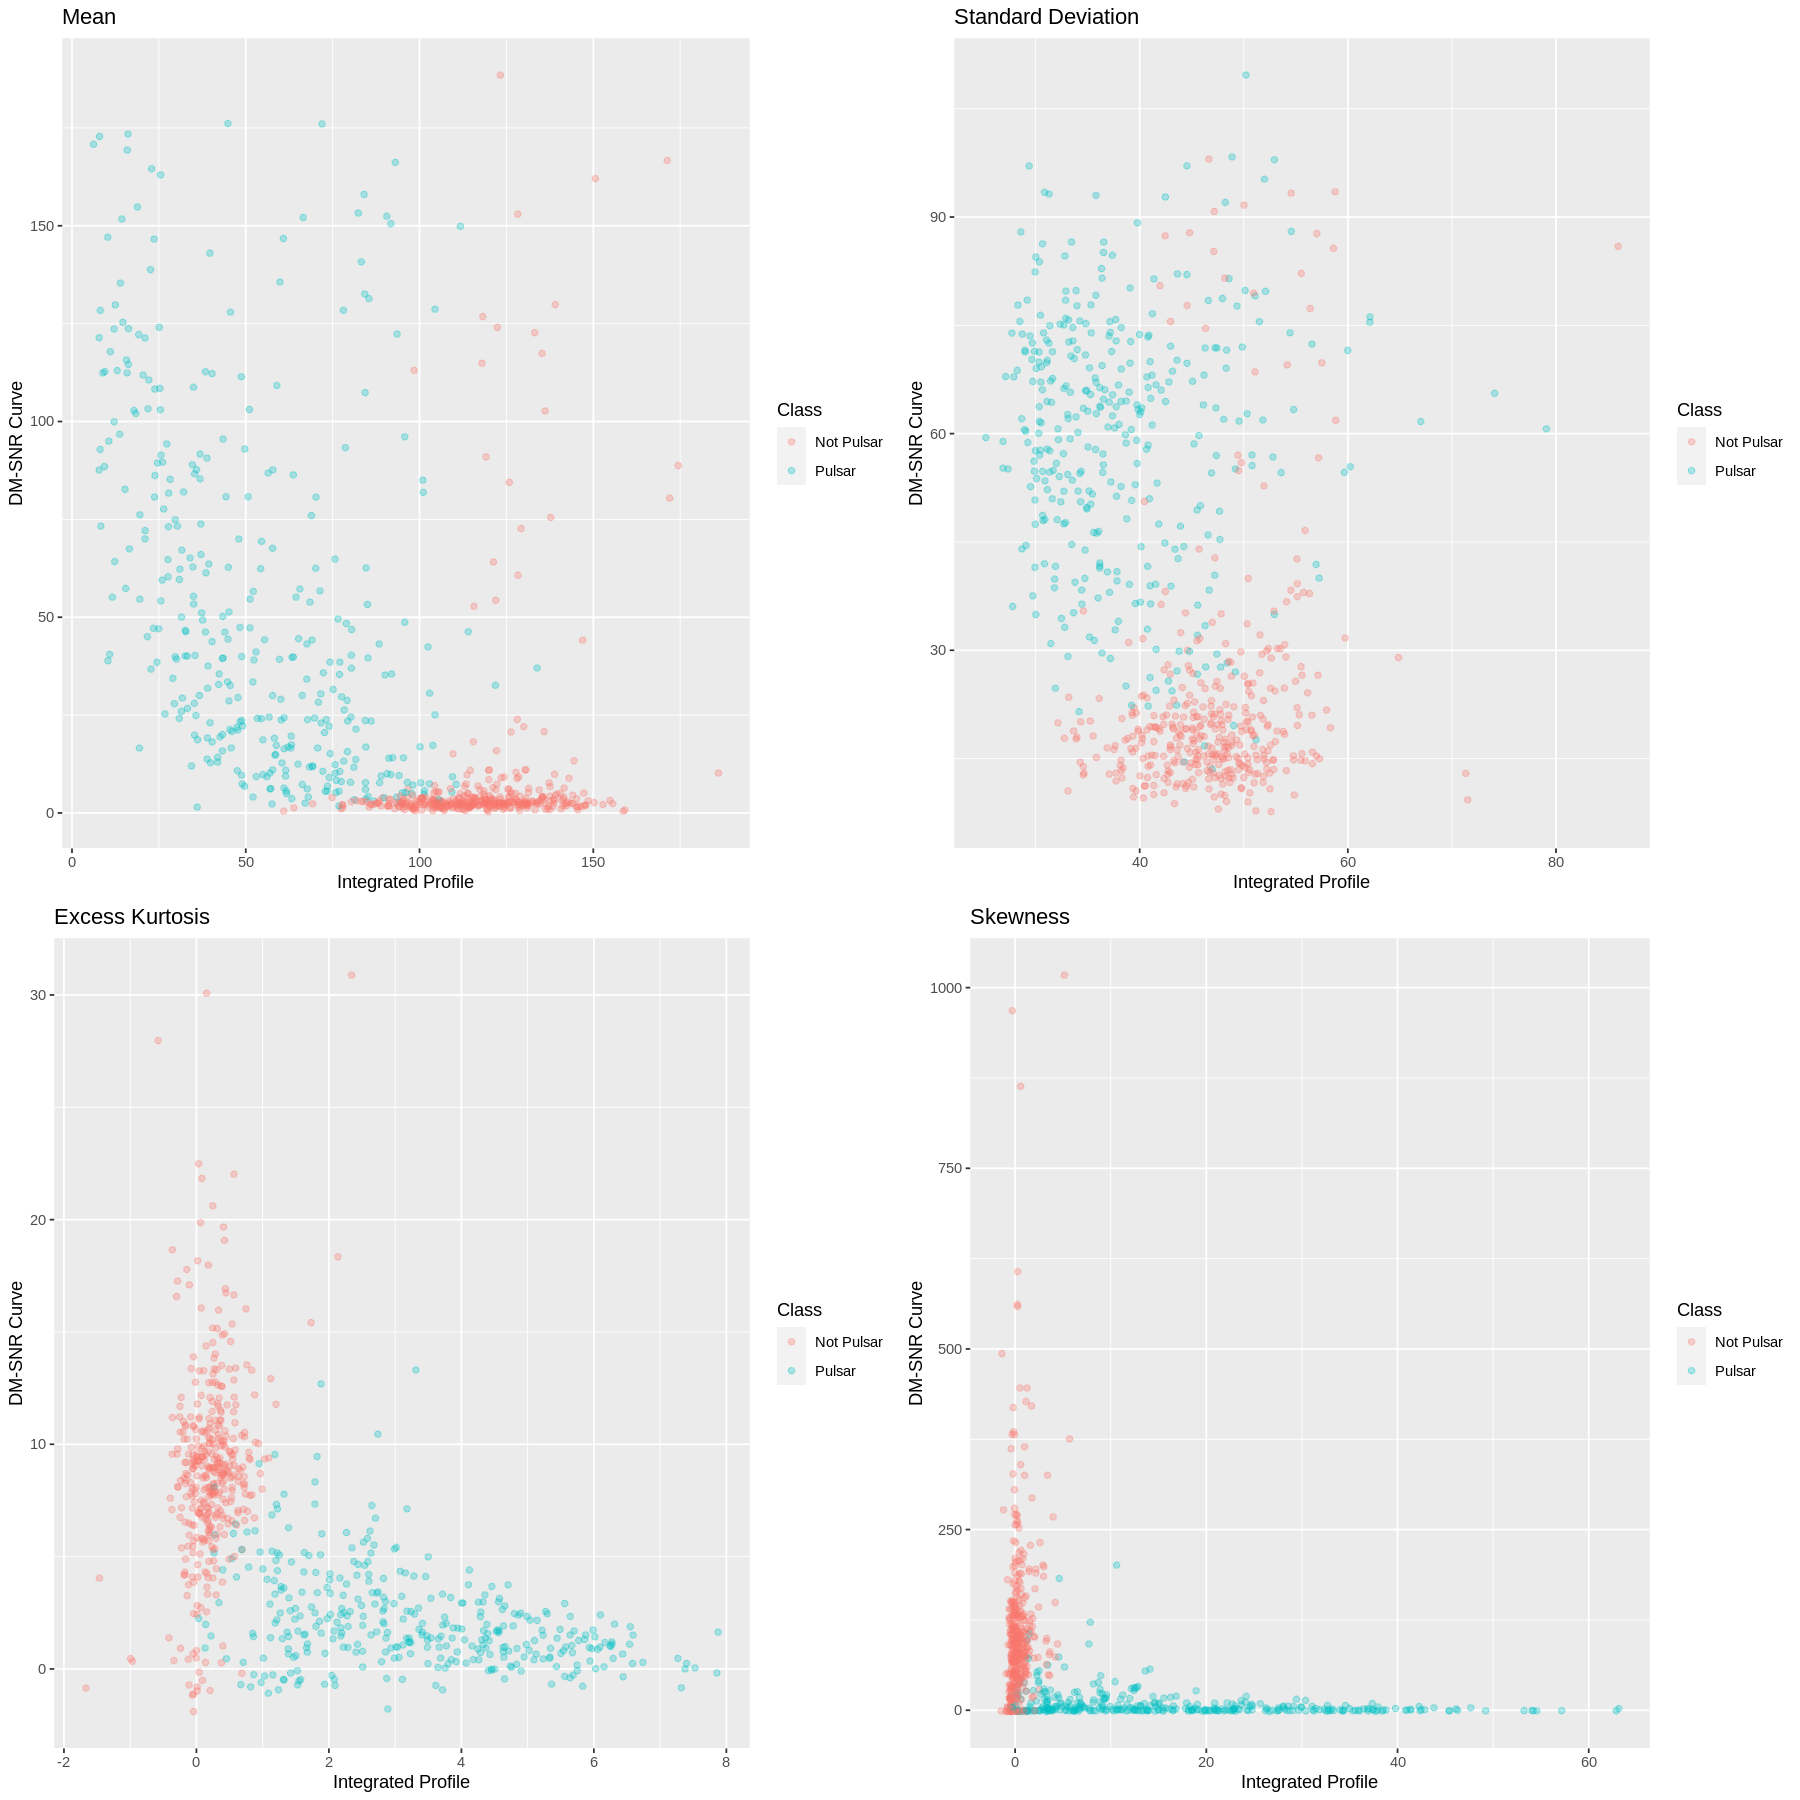

In [42]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_testing_plot_mean <-  ggplot(pulsar_predictions, aes(x = int_prof_mean, 
                                                     y = dm_snr_mean, 
                                                     colour = .pred_class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Mean",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_testing_plot_stan_dev <-  ggplot(pulsar_predictions, aes(x = int_prof_standard_deviation, 
                                                 y = dm_snr_standard_deviation, 
                                                 colour = .pred_class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Standard Deviation",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_testing_plot_excess_kurtosis <-  ggplot(pulsar_predictions, aes(x = int_prof_excess_kurtosis, 
                                                        y = dm_snr_excess_kurtosis, 
                                                        colour = .pred_class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Excess Kurtosis",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

pulsar_testing_plot_skewness <-  ggplot(pulsar_predictions, aes(x = int_prof_skewness, 
                                                 y = dm_snr_skewness, 
                                                 colour = .pred_class)) +
                        geom_point(alpha = 0.3) +
                        labs(x = "Integrated Profile",
                             y = "DM-SNR Curve",
                             title = "Skewness",
                             colour = "Class") +
                        scale_color_hue(labels = c("Not Pulsar", "Pulsar"))

grid.arrange(pulsar_testing_plot_mean,
             pulsar_testing_plot_stan_dev,
             pulsar_testing_plot_excess_kurtosis,
             pulsar_testing_plot_skewness,
             ncol = 2)

**Figure 3:** Plot of the statistics of Integrated Profile vs DM-SNR Curve using the predicted class

From the plots in Figure 3, we can see that our model's predictions mimics the shape of our data which shows that the model has a high confidence and accuracy.

It is found that classifying pulsar stars using a k nearest neighbors algorithm is a viable approach. With about 3,000 data points, the model has a high probability and confidence to tell whether a star is a pulsar or not. From the plots in Figure 1, it was expected to achieve a high accuracy, and the model confirmed this assumption with its 92.93% accuracy.

With the advancement of the ability to classify pulsar stars, a seemingly random star with characteristics that are hard to observe by the eye could be immediately classified by the model as long as its quantitative characteristics are recorded. This would allow us to further study galaxies beyond the solar system as well as learn more about the extreme states of matter. Furthermore, this would allow us to think whether we could replicate these phenomena here on earth in order to achieve more technological advancement.


References:

Lorimer, D. R., &amp; Kramer, M. (2012). Handbook of Pulsar Astronomy. Cambridge University Press. 

Shaw, B. S. (2021, September 30). Predicting pulsar stars: An imbalanced classification task comparing Bootstrap Resampling to smote. Medium.    Retrieved April 9, 2022, from https://towardsdatascience.com/predicting-pulsar-stars-an-imbalanced-classification-task-comparing-bootstrap-resampling-to-smote-8cfbe037b807